# Proof of concept notebook for the Frame Booster project
- Author: Kamil Barszczak
- Contact: kamilbarszczak62@gmail.com
- Project: https://github.com/kbarszczak/Frame_booster

In [96]:
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
import numpy as np
import pickle
import keras
import time
import cv2
import os

from keras import preprocessing
from keras import regularizers
from keras import activations
from keras import optimizers
from keras import callbacks
from keras import layers
from keras import losses
from keras import models

from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [97]:
model_base_path = 'E:/OneDrive - Akademia Górniczo-Hutnicza im. Stanisława Staszica w Krakowie/Programming/Labs/Frame_booster/models'
data_base_path = 'E:/Data/Video_Frame_Interpolation/processed/med_motion'
data_creation_time = '1682234774'  #'1682234560'
model_name = 'frame_booster'
width, height = 256, 144  # 128, 72
batch_size = 4
epochs = 2
shuffle = True

## Load dataset & create generators

In [98]:
def load_data(base_path, creation_time, width, height):
    with open(os.path.join(base_path, f'x_train_{height}x{width}_{creation_time}.pickle'), 'rb') as file:
        x_train = pickle.load(file)
        
    with open(os.path.join(base_path, f'y_train_{height}x{width}_{creation_time}.pickle'), 'rb') as file:
        y_train = pickle.load(file)
        
    with open(os.path.join(base_path, f'x_test_{height}x{width}_{creation_time}.pickle'), 'rb') as file:
        x_test = pickle.load(file)
        
    with open(os.path.join(base_path, f'y_test_{height}x{width}_{creation_time}.pickle'), 'rb') as file:
        y_test = pickle.load(file)
        
    with open(os.path.join(base_path, f'x_valid_{height}x{width}_{creation_time}.pickle'), 'rb') as file:
        x_valid = pickle.load(file)
        
    with open(os.path.join(base_path, f'y_valid_{height}x{width}_{creation_time}.pickle'), 'rb') as file:
        y_valid = pickle.load(file)
        
    return (np.array(x_train)/255.0).astype('float32'), (np.array(x_test)/255.0).astype('float32'), (np.array(x_valid)/255.0).astype('float32'), (np.array(y_train)/255.0).astype('float32'), (np.array(y_test)/255.0).astype('float32'), (np.array(y_valid)/255.0).astype('float32')

In [99]:
x_train, x_test, x_valid, y_train, y_test, y_valid = load_data(
    data_base_path,
    data_creation_time,
    width, 
    height
)
if len(x_train) % batch_size != 0:
    x_train = x_train[0:len(x_train) - (len(x_train)%batch_size)]
    y_train = y_train[0:len(x_train)]
if len(x_test) % batch_size != 0:
    x_test = x_test[0:len(x_test) - (len(x_test)%batch_size)]
    y_test = y_test[0:len(x_test)]
if len(x_valid) % batch_size != 0:
    x_valid = x_valid[0:len(x_valid) - (len(x_valid)%batch_size)]
    y_valid = y_valid[0:len(x_valid)]

In [100]:
train_generator = ImageDataGenerator().flow(
    x = [x_train[:, 0, :, :], x_train[:, 1, :, :]],
    y = y_train,
    batch_size = batch_size,
    shuffle = shuffle,
)

test_generator = ImageDataGenerator().flow(
    x = [x_test[:, 0, :, :], x_test[:, 1, :, :]],
    y = y_test,
    batch_size = batch_size,
    shuffle = False,
)

valid_generator = ImageDataGenerator().flow(
    x = [x_valid[:, 0, :, :], x_valid[:, 1, :, :]],
    y = y_valid,
    batch_size = batch_size,
    shuffle = shuffle,
)

In [101]:
print(f'Train size: {len(train_generator)} of batch size: {train_generator.batch_size}')
print(f'Test size: {len(test_generator)} of batch size: {test_generator.batch_size}')
print(f'Validation size: {len(valid_generator)} of batch size: {valid_generator.batch_size}')

Train size: 206 of batch size: 4
Test size: 25 of batch size: 4
Validation size: 23 of batch size: 4


## Create loss functions

In [102]:
VGG_model = VGG16(include_top=False)
VGG_model_1 = models.Model(inputs=VGG_model.inputs, outputs=VGG_model.layers[2].output)
VGG_model_2 = models.Model(inputs=VGG_model.inputs, outputs=VGG_model.layers[5].output)
VGG_model_3 = models.Model(inputs=VGG_model.inputs, outputs=VGG_model.layers[9].output)
VGG_model_4 = models.Model(inputs=VGG_model.inputs, outputs=VGG_model.layers[13].output)
VGG_model_5 = models.Model(inputs=VGG_model.inputs, outputs=VGG_model.layers[17].output)

VGG_model_1.trainable = False
for layer in VGG_model_1.layers:
    layer.trainable = False
    
VGG_model_2.trainable = False
for layer in VGG_model_2.layers:
    layer.trainable = False
    
VGG_model_3.trainable = False
for layer in VGG_model_3.layers:
    layer.trainable = False
    
VGG_model_4.trainable = False
for layer in VGG_model_4.layers:
    layer.trainable = False
        
VGG_model_5.trainable = False
for layer in VGG_model_5.layers:
    layer.trainable = False

In [103]:
"""
The perceptual loss function compares two images that differ very little. 
It cares about the high-level features of the images.
"""
def perceptual(y_true, y_pred):
    vgg_true_1 = VGG_model_1(y_true)
    vgg_pred_1 = VGG_model_1(y_pred)
    
    vgg_true_2 = VGG_model_2(y_true)
    vgg_pred_2 = VGG_model_2(y_pred)
    
    vgg_true_3 = VGG_model_3(y_true)
    vgg_pred_3 = VGG_model_3(y_pred)
    
    vgg_true_4 = VGG_model_4(y_true)
    vgg_pred_4 = VGG_model_4(y_pred)
    
    vgg_true_5 = VGG_model_5(y_true)
    vgg_pred_5 = VGG_model_5(y_pred)

    vgg_1_mse = K.mean(K.square(vgg_true_1 - vgg_pred_1))
    vgg_2_mse = K.mean(K.square(vgg_true_2 - vgg_pred_2))
    vgg_3_mse = K.mean(K.square(vgg_true_3 - vgg_pred_3))
    vgg_4_mse = K.mean(K.square(vgg_true_4 - vgg_pred_4))
    vgg_5_mse = K.mean(K.square(vgg_true_5 - vgg_pred_5))

    return vgg_1_mse + vgg_2_mse + vgg_3_mse + vgg_4_mse + vgg_5_mse


"""
The L1 reconstruction loss function makes the final image colors 
look the same as the colors in the ground-truth image
"""
def l1(y_true, y_pred):
    return K.sum(K.abs(y_true - y_pred)) / (width*height)


"""
The PSNR loss function is responsible for boosting the overall quality of the image by reducing its noise 
(The higher the PSNR the better so we return 1 - PSNR because the loss function tries to minimize it)
"""
def psnr(y_true, y_pred):
    psnr = tf.image.psnr(y_true, y_pred, max_val = 1.0)
    return 1 - psnr / 20.0


"""
The SSIM loss function keeps the result image structure
(The more significant the SSIM the more similar the final image is)
"""
def ssim(y_true, y_pred):
    ssim = tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))
    return 1 - ssim

## Create custom layers for the model

In [104]:
"""
PyramidFeatureExtraction is a class that makes the pyramid of the input image of depth 4. Then the CNNs extracts 
features of the image at each level and concatenates them with the features captured from the previous level.
This layer output is a 4-dimensional tuple with extracted features from each level. The first element of that tuple
are the features from the finest level.
"""
class PyramidFeatureExtraction(layers.Layer):
    def __init__(self, filter_count=[16, 32, 64], filter_size=(3, 3), activation='relu', regularizer=None, **kwargs):
        super(PyramidFeatureExtraction, self).__init__(**kwargs)
        
        # for pyramid creation
        self.downsample_avg = layers.AveragePooling2D((2, 2))
        
        # for feature extration (those layers are shared)
        self.cnn_1st_level = layers.Conv2D(filter_count[0], filter_size, activation=activation, kernel_regularizer=regularizer, padding='same')
        self.cnn_2nd_level = layers.Conv2D(filter_count[1], filter_size, activation=activation, kernel_regularizer=regularizer, padding='same')
        self.cnn_3rd_level = layers.Conv2D(filter_count[2], filter_size, activation=activation, kernel_regularizer=regularizer, padding='same')
        
        # concatenation layers
        self.concat_2nd_level = layers.Concatenate()
        self.concat_3rd_level = layers.Concatenate()
        self.concat_4th_level = layers.Concatenate()
        
        self.filter_count = filter_count
        self.filter_size = filter_size
        self.activation = activation
        self.regularizer = regularizer
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "filter_count": self.filter_count,
            "filter_size": self.filter_size,
            "activation": self.activation,
            "regularizer": self.regularizer,
        })
        return config

    def call(self, inputs):
        # pyramid
        input_1 = inputs
        input_2 = self.downsample_avg(input_1)
        input_3 = self.downsample_avg(input_2)
        input_4 = self.downsample_avg(input_3)
        
        # feature extraction for layer 1
        input_1_column_1_row_1 = self.cnn_1st_level(input_1)
        input_2_column_1_row_2 = self.cnn_1st_level(input_2)
        input_3_column_1_row_3 = self.cnn_1st_level(input_3)
        input_4_column_1_row_4 = self.cnn_1st_level(input_4)
        
        # downsample layer 1
        input_1_column_2_row_2 = self.downsample_avg(input_1_column_1_row_1)
        input_2_column_2_row_3 = self.downsample_avg(input_2_column_1_row_2)
        input_3_column_2_row_4 = self.downsample_avg(input_3_column_1_row_3)
        
        # feature extraction for layer 2
        input_1_column_2_row_2 = self.cnn_2nd_level(input_1_column_2_row_2)
        input_2_column_2_row_3 = self.cnn_2nd_level(input_2_column_2_row_3)
        input_3_column_2_row_4 = self.cnn_2nd_level(input_3_column_2_row_4)
        
        # downsample layer 2
        input_1_column_3_row_3 = self.downsample_avg(input_1_column_2_row_2)
        input_2_column_3_row_4 = self.downsample_avg(input_2_column_2_row_3)
        
        # feature extraction for layer 3
        input_1_column_3_row_3 = self.cnn_3rd_level(input_1_column_3_row_3)
        input_2_column_3_row_4 = self.cnn_3rd_level(input_2_column_3_row_4)
        
        # concatenate
        concat_1st = input_1_column_1_row_1
        concat_2nd = self.concat_2nd_level([input_2_column_1_row_2, input_1_column_2_row_2])
        concat_3rd = self.concat_3rd_level([input_3_column_1_row_3, input_2_column_2_row_3, input_1_column_3_row_3])
        concat_4th = self.concat_4th_level([input_4_column_1_row_4, input_3_column_2_row_4, input_2_column_3_row_4])
        
        return concat_1st, concat_2nd, concat_3rd, concat_4th

In [105]:
"""
BidirectionalFlowEstimation is a layer that warps the features extracted at the given level trying 
to modify them to fit the target image. It predicts the flow between features of both the input_1 
and the input_2 and warps them to get the final output. The output shape is the same as the input shape.
"""
class BidirectionalFlowEstimation(layers.Layer):
    def __init__(self, filter_count=[32, 64, 64, 16], filter_size=[(3, 3), (3, 3), (1, 1), (1, 1)], activation='relu', regularizer=None, interpolation='bilinear', **kwargs):
        super(BidirectionalFlowEstimation, self).__init__(**kwargs)
        
        # flow 1 -> 2
        self.flow_add_1_2 = layers.Add()
        self.flow_upsample_1_2 = layers.UpSampling2D((2, 2), interpolation=interpolation)
        self.flow_1_2_concat = layers.Concatenate(axis=3)
        self.flow_prediction_1_2 =  keras.Sequential([
            layers.Conv2D(filter_count[0], filter_size[0], activation=activation, kernel_regularizer=regularizer, padding='same'),
            layers.Conv2D(filter_count[1], filter_size[1], activation=activation, kernel_regularizer=regularizer, padding='same'),
            layers.Conv2D(filter_count[2], filter_size[2], activation=activation, kernel_regularizer=regularizer, padding='same'),
            layers.Conv2D(filter_count[3], filter_size[3], activation=activation, kernel_regularizer=regularizer, padding='same'),
            layers.Conv2D(2, (1, 1), kernel_regularizer=regularizer, padding='same')
        ])
        
        # flow 2 -> 1
        self.flow_add_2_1 = layers.Add()
        self.flow_upsample_2_1 = layers.UpSampling2D((2, 2), interpolation=interpolation)
        self.flow_2_1_concat = layers.Concatenate(axis=3)
        self.flow_prediction_2_1 = keras.Sequential([
            layers.Conv2D(filter_count[0], filter_size[0], activation=activation, kernel_regularizer=regularizer, padding='same'),
            layers.Conv2D(filter_count[1], filter_size[1], activation=activation, kernel_regularizer=regularizer, padding='same'),
            layers.Conv2D(filter_count[2], filter_size[2], activation=activation, kernel_regularizer=regularizer, padding='same'),
            layers.Conv2D(filter_count[3], filter_size[3], activation=activation, kernel_regularizer=regularizer, padding='same'),
            layers.Conv2D(2, (1, 1), kernel_regularizer=regularizer, padding='same')
        ])
        
        self.filter_count = filter_count
        self.filter_size = filter_size
        self.activation = activation
        self.regularizer = regularizer
        self.interpolation = interpolation
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "filter_count": self.filter_count,
            "filter_size": self.filter_size,
            "activation": self.activation,
            "regularizer": self.regularizer,
            "interpolation": self.interpolation,
        })
        return config

    def call(self, inputs):
        input_1 = inputs[0]
        input_2 = inputs[1]
        flow_1_2 = inputs[2]
        flow_2_1 = inputs[3]
        
        # input_1 to input_2 flow prediction
        input_1_warped_1 = tfa.image.dense_image_warp(input_1, flow_1_2)
            
        flow_change_1_2_concat = self.flow_1_2_concat([input_2, input_1_warped_1])
        flow_change_1_2 = self.flow_prediction_1_2(flow_change_1_2_concat)
        
        flow_1_2_changed = self.flow_add_1_2([flow_1_2, flow_change_1_2])
        input_1_warped_2 = tfa.image.dense_image_warp(input_1, flow_1_2_changed)
        flow_1_2_changed_upsampled = self.flow_upsample_1_2(flow_1_2_changed)
        
        # input_2 to input_1 flow prediction
        input_2_warped_1 = tfa.image.dense_image_warp(input_2, flow_2_1)
            
        flow_change_2_1_concat = self.flow_2_1_concat([input_1, input_2_warped_1])
        flow_change_2_1 = self.flow_prediction_2_1(flow_change_2_1_concat)

        flow_2_1_changed = self.flow_add_2_1([flow_2_1, flow_change_2_1])
        input_2_warped_2 = tfa.image.dense_image_warp(input_2, flow_2_1_changed)
        flow_2_1_changed_upsampled = self.flow_upsample_2_1(flow_2_1_changed)
        
        return input_1_warped_2, input_2_warped_2, flow_1_2_changed_upsampled, flow_2_1_changed_upsampled

In [106]:
"""
This output functions cuts the linear function to the range from 0 to 1
"""
def output_activation(x):
    return tf.math.minimum(tf.math.maximum(x, 0), 1)


"""
WarpedFeatureFusion is a layer that concatenates and fuses all the warped features 
obtained from the FlowEstimator layer. This layer generates the final output.
"""
class WarpedFeatureFusion(layers.Layer):
    def __init__(self, feature_extractor_filter_count=[16, 32, 64], filter_size=(3, 3), activation='relu', regularizer=None, interpolation='bilinear', **kwargs):
        super(WarpedFeatureFusion, self).__init__(**kwargs)
        fefc = feature_extractor_filter_count
        
        self.cnn_1st_level_o = layers.Conv2D(3, (1, 1), activation=output_activation, padding='same')
        self.add_1st_level = layers.Add()
        
        self.up_2nd_level = layers.UpSampling2D((2, 2), interpolation=interpolation)
        self.cnn_2nd_level_2 = layers.Conv2D(fefc[0], filter_size, activation=activation, kernel_regularizer=regularizer, padding='same')
        self.cnn_2nd_level_1 = layers.Conv2D(fefc[0], filter_size, activation=activation, kernel_regularizer=regularizer, padding='same')
        self.add_2nd_level = layers.Add()
        
        self.up_3rd_level = layers.UpSampling2D((2, 2), interpolation=interpolation)
        self.cnn_3rd_level_2 = layers.Conv2D(fefc[0] + fefc[1], filter_size, activation=activation, kernel_regularizer=regularizer, padding='same')
        self.cnn_3rd_level_1 = layers.Conv2D(fefc[0] + fefc[1], filter_size, activation=activation, kernel_regularizer=regularizer, padding='same')
        self.add_3rd_level = layers.Add()
        
        self.up_4th_level = layers.UpSampling2D((2, 2), interpolation=interpolation)
        self.cnn_4th_level_2 = layers.Conv2D(fefc[0] + fefc[1] + fefc[2], filter_size, activation=activation, kernel_regularizer=regularizer, padding='same')
        self.cnn_4th_level_1 = layers.Conv2D(fefc[0] + fefc[1] + fefc[2], filter_size, activation=activation, kernel_regularizer=regularizer, padding='same')
        self.add_4th_level = layers.Add()
        
        self.feature_extractor_filter_count = feature_extractor_filter_count
        self.filter_size = filter_size
        self.activation = activation
        self.regularizer = regularizer
        self.interpolation = interpolation
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "feature_extractor_filter_count": self.feature_extractor_filter_count,
            "filter_size": self.filter_size,
            "activation": self.activation,
            "regularizer": self.regularizer,
            "interpolation": self.interpolation,
        })
        return config
    
    def call(self, inputs):
        input_1 = inputs[0]
        input_2 = inputs[1]
        
        # merge 4th level
        added_4th_level = self.add_4th_level([input_1[3], input_2[3]])
        cnn_4th_1 = self.cnn_4th_level_1(added_4th_level)
        cnn_4th_2 = self.cnn_4th_level_2(cnn_4th_1)
        up_4th = self.up_4th_level(cnn_4th_2)
        
        # merge 3rd level
        added_3rd_level = self.add_3rd_level([input_1[2], input_2[2], up_4th])
        cnn_3rd_1 = self.cnn_3rd_level_1(added_3rd_level)
        cnn_3rd_2 = self.cnn_3rd_level_2(cnn_3rd_1)
        up_3rd = self.up_3rd_level(cnn_3rd_2)
        
        # merge 2nd level
        added_2nd_level = self.add_2nd_level([input_1[1], input_2[1], up_3rd])
        cnn_2nd_1 = self.cnn_2nd_level_1(added_2nd_level)
        cnn_2nd_2 = self.cnn_2nd_level_2(cnn_2nd_1)
        up_2nd = self.up_3rd_level(cnn_2nd_2)
        
        # merge 1st level
        added_1st_level = self.add_1st_level([input_1[0], input_2[0], up_2nd])
        outputs = self.cnn_1st_level_o(added_1st_level)
    
        return outputs

In [107]:
"""
FBNet is a layer that merges all the custom layers declared above making
the full ready-to-use frame interpolation network.
"""
class FBNet(layers.Layer):
    def __init__(self, pyramid_filter_count=[16, 32, 64], pyramid_filter_size=(3, 3), flow_filter_count=[32, 64, 64, 16], flow_filter_sizes=[(3, 3), (3, 3), (1, 1), (1, 1)], activation='relu', regularizer=None, interpolation='bilinear', **kwargs):
        super(FBNet, self).__init__(**kwargs)
        
        assert len(pyramid_filter_count) == 3, 'pyramid_filter_count length is expected to be 3. Got: ' + str(len(pyramid_filter_count))
        assert len(pyramid_filter_size) == 2, 'pyramid_filter_size length is expected to be 2. Got: ' + str(len(pyramid_filter_size))
        assert len(flow_filter_count) == 4, 'flow_filter_count length is expected to be 4. Got ' + str(len(flow_filter_count))
        assert len(flow_filter_sizes) == 4, 'flow_filter_sizes length is expected to be 4. Got ' + str(len(flow_filter_sizes))
        
        # for building the pyramid
        self.pyramid_input_1 = PyramidFeatureExtraction(
            filter_count=pyramid_filter_count, 
            filter_size=pyramid_filter_size, 
            activation=activation, 
            regularizer=regularizer
        )
        self.pyramid_input_2 = PyramidFeatureExtraction(
            filter_count=pyramid_filter_count, 
            filter_size=pyramid_filter_size, 
            activation=activation, 
            regularizer=regularizer
        )
        
        # for flow estimation
        self.bidirectional_flow_estimation_1 = BidirectionalFlowEstimation(
            filter_count=flow_filter_count, 
            filter_size=flow_filter_sizes, 
            activation=activation, 
            regularizer=regularizer, 
            interpolation=interpolation
        )
        self.bidirectional_flow_estimation_2 = BidirectionalFlowEstimation(
            filter_count=flow_filter_count, 
            filter_size=flow_filter_sizes, 
            activation=activation, 
            regularizer=regularizer, 
            interpolation=interpolation
        )
        self.bidirectional_flow_estimation_3 = BidirectionalFlowEstimation(
            filter_count=flow_filter_count, 
            filter_size=flow_filter_sizes, 
            activation=activation, 
            regularizer=regularizer, 
            interpolation=interpolation
        )
        self.bidirectional_flow_estimation_4 = BidirectionalFlowEstimation(
            filter_count=flow_filter_count, 
            filter_size=flow_filter_sizes, 
            activation=activation, 
            regularizer=regularizer, 
            interpolation=interpolation
        )
        
        # for the final fusion
        self.warped_feature_fusion = WarpedFeatureFusion(
            feature_extractor_filter_count=pyramid_filter_count, 
            filter_size=pyramid_filter_size, 
            activation=activation, 
            regularizer=regularizer, 
            interpolation=interpolation
        )
        
        self.pyramid_filter_count = pyramid_filter_count
        self.pyramid_filter_size = pyramid_filter_size
        self.flow_filter_count = flow_filter_count
        self.flow_filter_sizes = flow_filter_sizes
        self.activation = activation
        self.regularizer = regularizer
        self.interpolation = interpolation
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "pyramid_filter_count": self.pyramid_filter_count,
            "pyramid_filter_size": self.pyramid_filter_size,
            "flow_filter_count": self.flow_filter_count,
            "flow_filter_sizes": self.flow_filter_sizes,
            "activation": self.activation,
            "regularizer": self.regularizer,
            "interpolation": self.interpolation,
        })
        return config
    
    def call(self, inputs):
        # these are the input images
        input_1 = inputs[0]
        input_2 = inputs[1]

        # feature extractor layers for each image indepedantly
        feature_extraction_1 = self.pyramid_input_1(input_1)
        feature_extraction_2 = self.pyramid_input_2(input_2)

        # create empty flow for the coarest level
        empty_flow_1 = tf.zeros(shape=(batch_size, feature_extraction_1[3].shape[1], feature_extraction_1[3].shape[2], 2))
        empty_flow_2 = tf.zeros(shape=(batch_size, feature_extraction_1[3].shape[1], feature_extraction_1[3].shape[2], 2))

        # calculate the flow for each level using the input of current level and the upsampled flow from the level + 1
        bfe_4_i1, bfe_4_i2, bfe_4_f_1_2, bfe_4_f_2_1 = self.bidirectional_flow_estimation_1([feature_extraction_1[3], feature_extraction_2[3], empty_flow_1, empty_flow_2])
        bfe_3_i1, bfe_3_i2, bfe_3_f_1_2, bfe_3_f_2_1 = self.bidirectional_flow_estimation_2([feature_extraction_1[2], feature_extraction_2[2], bfe_4_f_1_2, bfe_4_f_2_1])
        bfe_2_i1, bfe_2_i2, bfe_2_f_1_2, bfe_2_f_2_1 = self.bidirectional_flow_estimation_3([feature_extraction_1[1], feature_extraction_2[1], bfe_3_f_1_2, bfe_3_f_2_1])
        bfe_1_i1, bfe_1_i2, _, _ = self.bidirectional_flow_estimation_4([feature_extraction_1[0], feature_extraction_2[0], bfe_2_f_1_2, bfe_2_f_2_1])

        # merge the features extracted by the previous layers
        outputs = self.warped_feature_fusion([(bfe_1_i1, bfe_2_i1, bfe_3_i1, bfe_4_i1), (bfe_1_i2, bfe_2_i2, bfe_3_i2, bfe_4_i2)])

        return outputs

## Create the final custom loss function & build the model

In [108]:
def loss(y_true, y_pred):
    ssim_ = ssim(y_true, y_pred)
    psnr_ = psnr(y_true, y_pred)
#     perceptual_ = perceptual(y_true, y_pred)
    l1_ = l1(y_true, y_pred)
#     return 1.5*ssim_ + 20*perceptual_ + 1.0*psnr_ + 0.08*l1_
    return ssim_ + psnr_ + l1_

In [109]:
# create input layers
inputs = [layers.Input(shape=(height, width, 3)), layers.Input(shape=(height, width, 3))]

# create the net
fb_net = FBNet(
    pyramid_filter_count = [16, 32, 64], 
    pyramid_filter_size = (3, 3), 
    flow_filter_count = [32, 64, 64, 16], 
    flow_filter_sizes = [(3, 3), (3, 3), (1, 1), (1, 1)],
    activation = 'relu', 
    regularizer = None, 
    interpolation = 'bilinear'
)

# create the output layer
outputs = fb_net(inputs)

# create and compile the model
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    loss = loss,
    optimizer = optimizers.Nadam(0.001),
    metrics = [perceptual, l1, psnr, ssim]
)

model.summary(expand_nested = True)

Model: "model_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 144, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_31 (InputLayer)          [(None, 144, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 fb_net_12 (FBNet)              (4, 144, 256, 3)     873571      ['input_30[0][0]',               
                                                                  'input_31[0][0]']        

## Train the model

In [110]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data = valid_generator,
#     callbacks = [
#         callbacks.ModelCheckpoint(
#             os.path.join(model_base_path, f'{model_name}_{int(time.time())}_'+'{val_loss:.4f}_{epochs:02d}.h5'),
#             monitor = 'val_loss',
#             mode = 'min',
#             save_best_only = True,
#             save_weights_only = False,
#             initial_value_threshold=5
#         )
#     ]
)

Epoch 1/5
206/206 [==============================] - 96s 404ms/step - loss: 2.8942 - perceptual: 64.6322 - l1: 1.9300 - psnr: 0.2776 - ssim: 0.6866 - val_loss: 2.1703 - val_perceptual: 56.3221 - val_l1: 1.3861 - val_psnr: 0.1758 - val_ssim: 0.6083
Epoch 2/5
206/206 [==============================] - 80s 388ms/step - loss: 1.9731 - perceptual: inf - l1: 1.2160 - psnr: 0.1472 - ssim: 0.6099 - val_loss: 1.9047 - val_perceptual: 54.4051 - val_l1: 1.1836 - val_psnr: 0.1367 - val_ssim: 0.5843
Epoch 3/5
206/206 [==============================] - 81s 391ms/step - loss: 1.8872 - perceptual: nan - l1: 1.1635 - psnr: 0.1314 - ssim: 0.5923 - val_loss: 1.8153 - val_perceptual: 53.1536 - val_l1: 1.1262 - val_psnr: 0.1201 - val_ssim: 0.5690
Epoch 4/5
206/206 [==============================] - 80s 389ms/step - loss: 1.8344 - perceptual: inf - l1: 1.1320 - psnr: 0.1208 - ssim: 0.5816 - val_loss: 1.7549 - val_perceptual: inf - val_l1: 1.0881 - val_psnr: 0.1086 - val_ssim: 0.5583
Epoch 5/5
206/206 [=====

## Evaluate the training

In [111]:
def norm_0_1(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def norm(data):
    return (data - np.mean(data)) / np.std(data)

In [112]:
def plot_history(history, normalize_method=None, metrics_restrictions=None):
    plt.clf()
    plt.figure(figsize=(25,10))
    
    metrics = list(history.keys())
    metrics = [metric for metric in metrics if "val" not in metric]
    if metrics_restrictions is not None:
        metrics = [metric for metric in metrics if metric in metrics_restrictions]
    
    data = [(index, history[metric], history['val_'+metric], metric) for index, metric in enumerate(metrics)]
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    epochs = range(1, len(data[0][1]) + 1)
    
    for index, value, val_value, metric in data:
        if normalize_method is not None:
            buffer = value.copy()
            buffer.extend(val_value)
            buffer = normalize_method(buffer)
            value = buffer[0:len(epochs)]
            val_value = buffer[len(epochs)::]
        
        plt.plot(epochs, value, colors[index], label=f"Training {metric}")
        plt.plot(epochs, val_value, colors[index]+'--', label=f"Validation {metric}")
        
    plt.xticks(epochs, size=17)    
    plt.yticks(size=17)
    plt.title(f"Comparison of Training and Validation metrics", size=20)
    plt.xlabel('Epochs', size=17)
    plt.ylabel("Metric values", size=17)
    plt.legend(loc='upper right', fontsize=14)
    plt.show()

In [113]:
def evaluate(model, generator):
    result_dict = {}
    result = model.evaluate(generator, verbose=0)
    for index, metric in enumerate(model.metrics):
        result_dict[metric.name] = result[index]
        print(f'{metric.name.zfill(13).replace("0", " ")}: {np.round(result[index], 4)}')
        
    return result_dict

<Figure size 640x480 with 0 Axes>

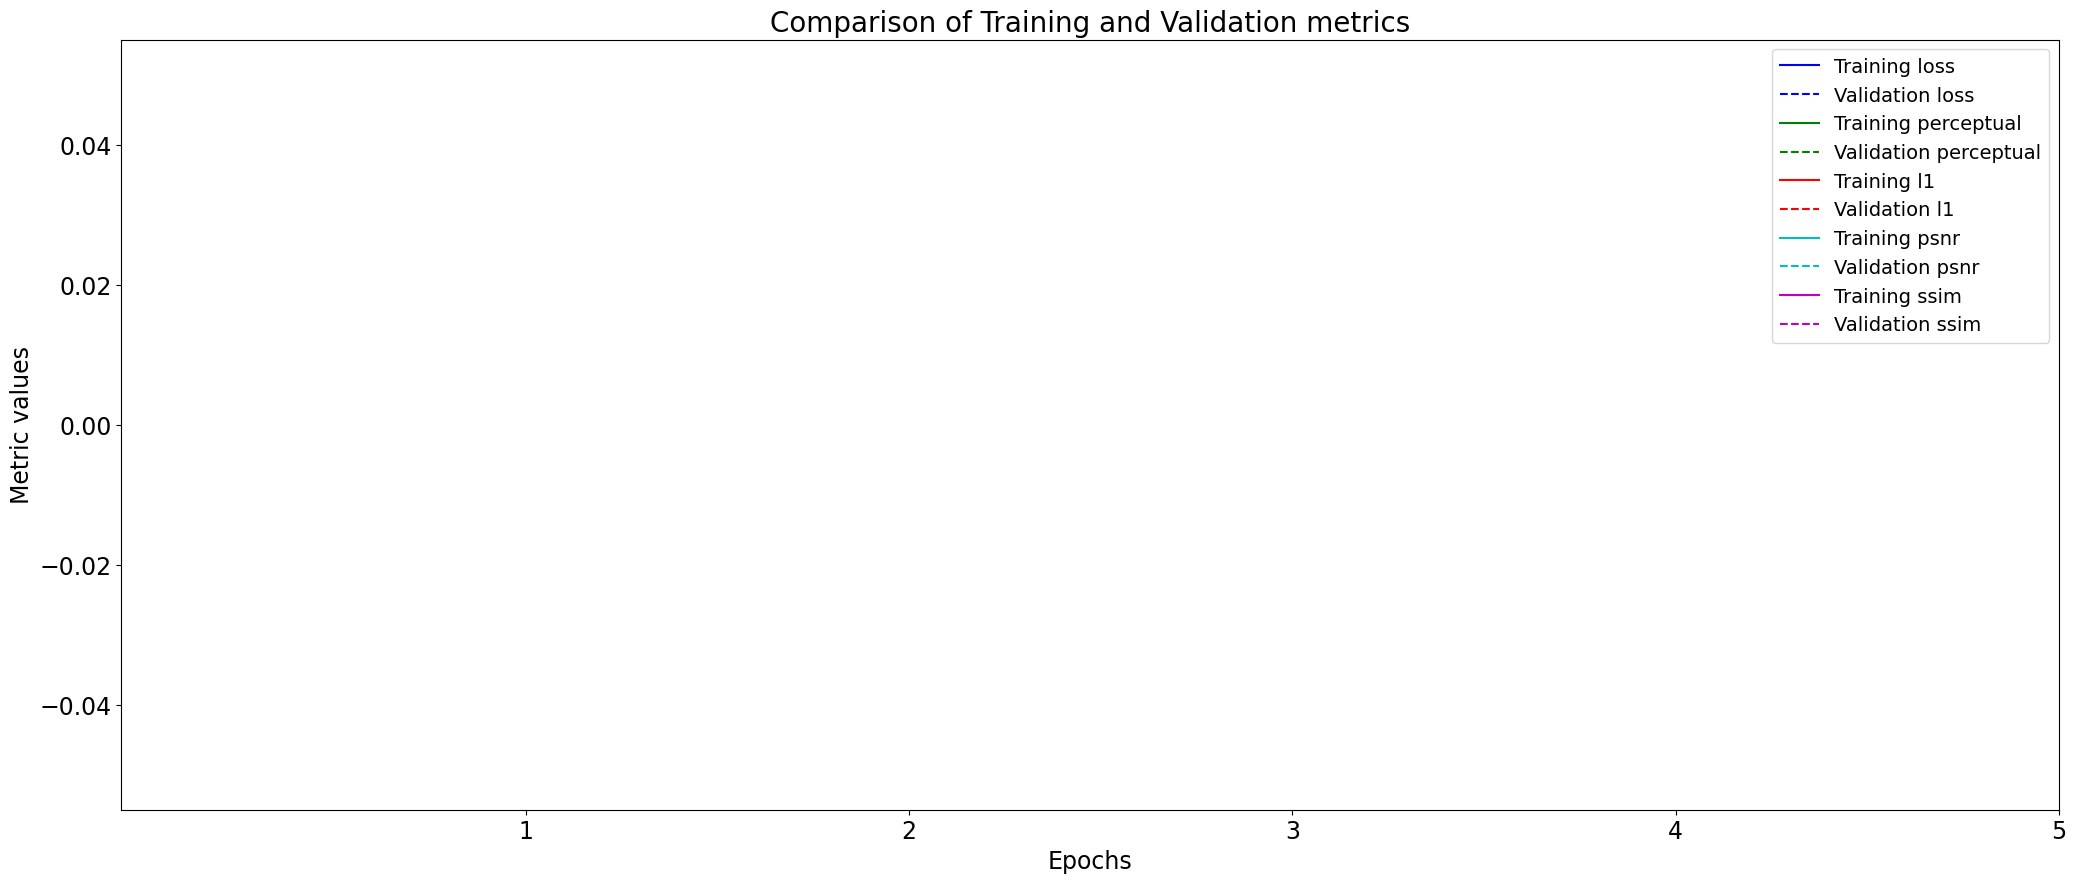

In [114]:
plot_history(history.history, normalize_method=norm)

<Figure size 640x480 with 0 Axes>

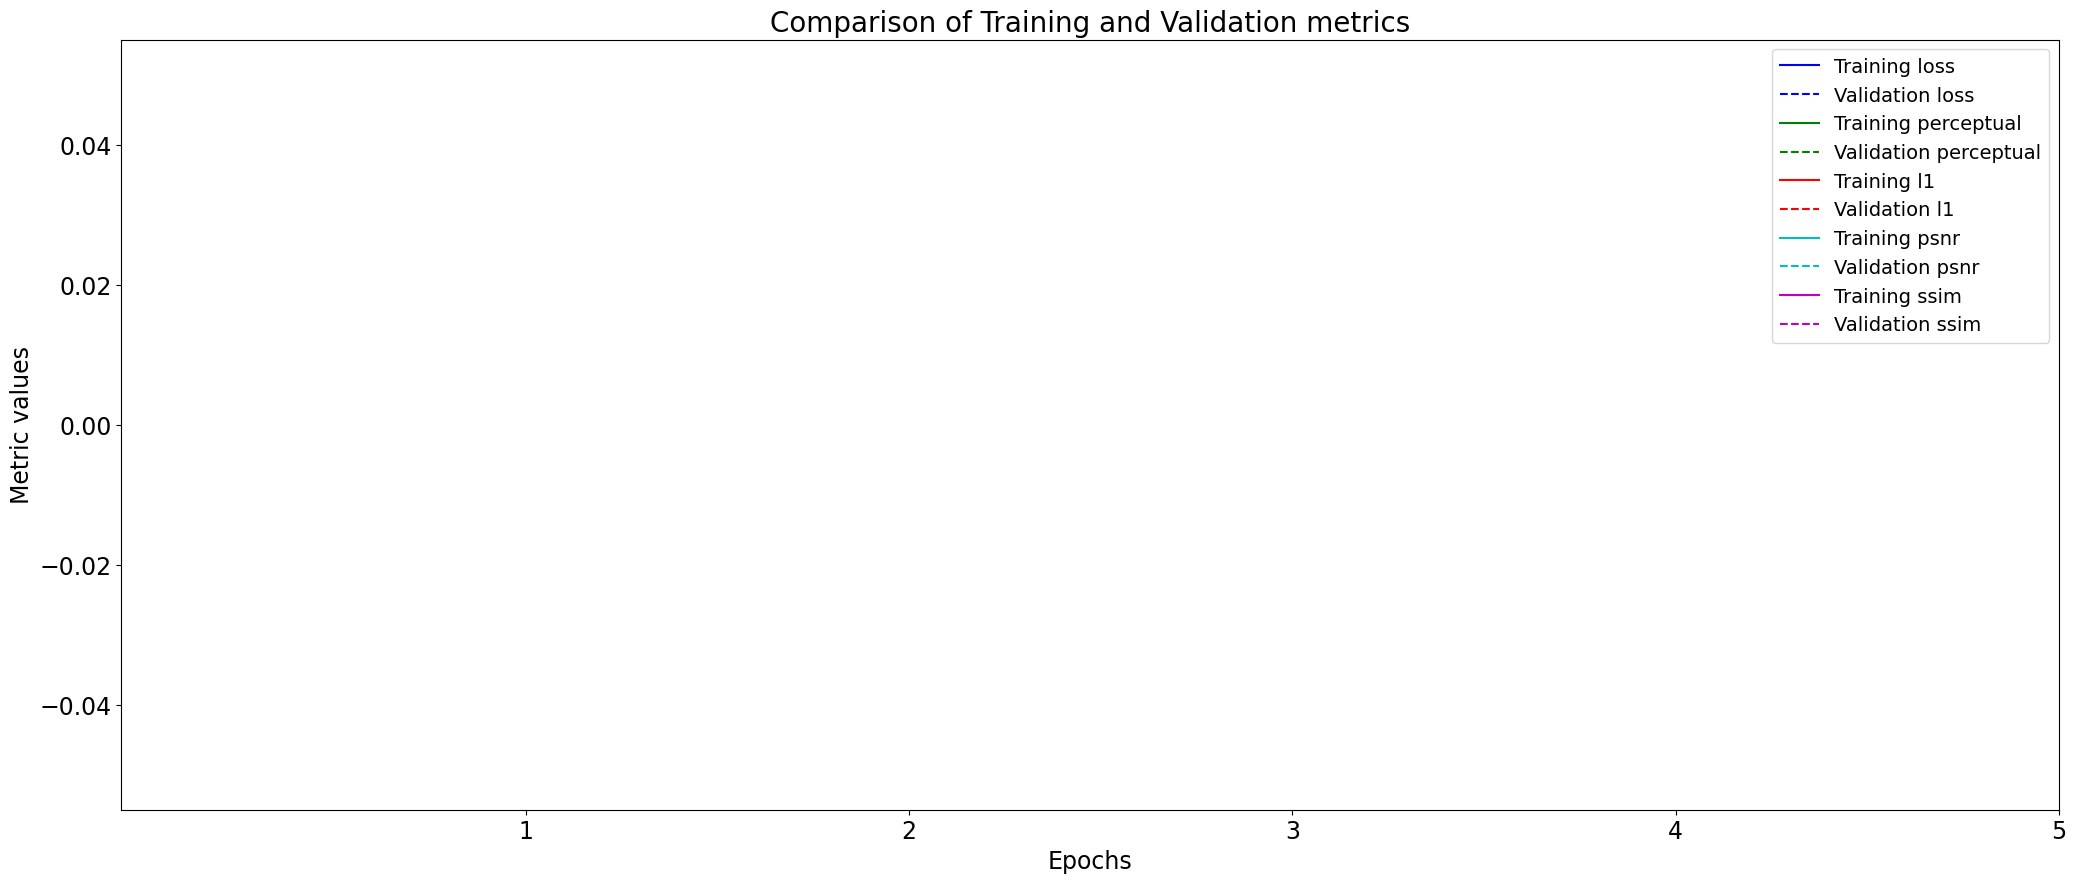

In [115]:
plot_history(history.history, normalize_method=norm_0_1)

<Figure size 640x480 with 0 Axes>

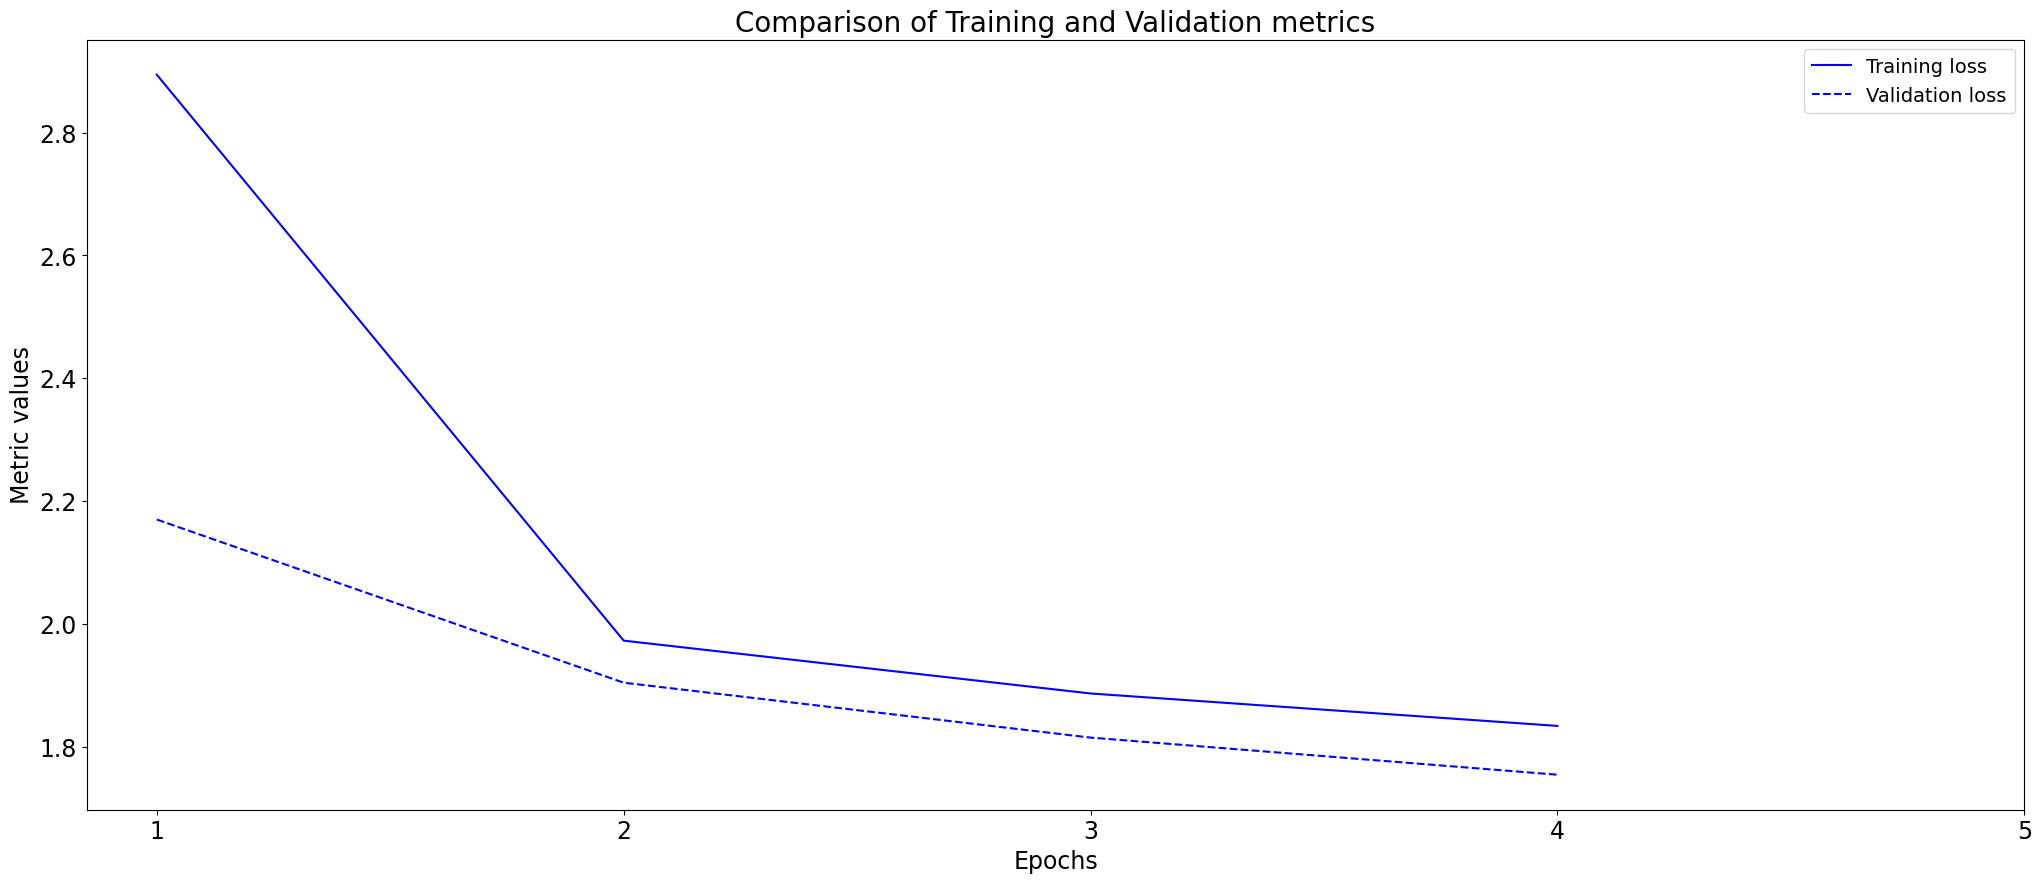

In [116]:
plot_history(history.history, normalize_method=None, metrics_restrictions=['loss'])

In [117]:
_ = evaluate(model, test_generator)

         loss: nan
   perceptual: nan
           l1: nan
         psnr: nan
         ssim: nan


## Visualize generated frames

In [118]:
predictions = model.predict(test_generator)

25/25 [==============================] - 4s 71ms/step


In [119]:
def visualize(test_generator, predictions, batch, index):
    # verify arguments
    batch_size = test_generator.batch_size
    assert test_generator.shuffle == False
    assert batch >= 0 and batch < len(test_generator)
    assert index >= 0 and index < batch_size
    
    # get neighbours frames
    neighbours, true = test_generator[batch]
    neighbours = np.array(neighbours)
    neighbours = neighbours[:, index, :, :, :]

    # get true and predicted frames
    true = np.array(true)[index]
    predicted = predictions[batch_size*batch + index]
    
    # mark true edges on predicted frame
    true_edges = cv2.cvtColor(true, cv2.COLOR_RGB2GRAY)
    true_edges = cv2.GaussianBlur(true_edges, (3, 3), 1)
    true_edges = cv2.medianBlur(true_edges, 3)
    true_edges = cv2.Canny((true_edges*255).astype('uint8'), 50, 100)
    predicted_marked = predicted.copy()
    predicted_marked[true_edges != 0] = (1, 1, 1)

    # plot images
    f, ax = plt.subplots(3, 2)
    f.set_size_inches(20, 20)

    ax[0][0].set_title("First frame")
    ax[0][0].set_xticks([])
    ax[0][0].set_yticks([])
    ax[0][0].imshow(neighbours[0])
    
    ax[1][0].set_title("Predicted frame")
    ax[1][0].set_xticks([])
    ax[1][0].set_yticks([])
    ax[1][0].imshow(predicted)
    
    ax[2][0].set_title("Second frame")
    ax[2][0].set_xticks([])
    ax[2][0].set_yticks([])
    ax[2][0].imshow(neighbours[1])
    
    ax[0][1].set_title("Predicted and Ground-truth difference")
    ax[0][1].set_xticks([])
    ax[0][1].set_yticks([])
    ax[0][1].imshow(cv2.absdiff(predicted, true))
    
    ax[1][1].set_title("Ground-truth frame")
    ax[1][1].set_xticks([])
    ax[1][1].set_yticks([])
    ax[1][1].imshow(true)
    
    ax[2][1].set_title("Edge shift")
    ax[2][1].set_xticks([])
    ax[2][1].set_yticks([])
    ax[2][1].imshow(predicted_marked)

In [ ]:
visualize(test_generator, predictions, 0, 0)

In [ ]:
visualize(test_generator, predictions, 1, 3)

In [ ]:
visualize(test_generator, predictions, 2, 1)

In [ ]:
visualize(test_generator, predictions, 3, 1)

## Visualize the inner of the net

In [ ]:
#TODO: 

## Save or load the model

In [ ]:
model_creation_time = int(time.time())
model.save(os.path.join(model_base_path, f'{model_name}_{model_creation_time}.h5'))

In [ ]:
model = keras.models.load_model(
    os.path.join(model_base_path, f'{model_name}_{model_creation_time}.h5'),
    custom_objects = {
        "PyramidFeatureExtraction": PyramidFeatureExtraction,
        "BidirectionalFlowEstimation": BidirectionalFlowEstimation,
        "WarpedFeatureFusion": WarpedFeatureFusion,
        'loss': loss,
        'perceptual': perceptual,
        'l1': l1,
        "ssim": ssim,
        "psnr": psnr
    }
)